In [1]:
import hyperspy.api as hs
import numpy  as np
import spglib as spg
import matplotlib.pyplot as plt

from EELS import system, spectrum
from matplotlib import colors
from scipy import signal

folder = "./"

# Define cells and symmetry
For parabolic bands, use a cubic symmetry

In [2]:
lattice = np.array([[ 3.2871687359128612, 0.0000000000000000, 0.0000000000000000],
                    [-1.6435843679564306, 2.8467716318265182, 0.0000000000000000],
                    [ 0.0000000000000000, 0.0000000000000000, 5.3045771064003047]])

positions = [[0.3333333333333357,  0.6666666666666643,  0.9996814330926364],
             [0.6666666666666643,  0.3333333333333357,  0.4996814330926362],
             [0.3333333333333357,  0.6666666666666643,  0.3787615522102606],
             [0.6666666666666643,  0.3333333333333357,  0.8787615522102604]]

numbers = [30, 30, 8, 8]

cell= (lattice, positions, numbers)
sym = spg.get_symmetry(cell, symprec=1e-5)
print(spg.get_spacegroup(cell, symprec=1e-5))

P6_3mc (186)


In [3]:
def brillouinZone(lattice):
    a = lattice[0]
    b = lattice[1]
    c = lattice[2]

    volume = a.dot(np.cross(b,c))
    
    a_r = 2*np.pi*np.cross(b,c)/volume
    b_r = 2*np.pi*np.cross(c,a)/volume
    c_r = 2*np.pi*np.cross(a,b)/volume
    return np.vstack([a_r,b_r,c_r])

In [4]:
BZ = brillouinZone(lattice)
BZ

array([[ 1.91142768,  1.10356328, -0.        ],
       [ 0.        ,  2.20712657,  0.        ],
       [ 0.        , -0.        ,  1.18448374]])

In [5]:
mesh = np.array([5, 5, 5]) # use odd numbers

In [6]:
mapping, grid = spg.get_ir_reciprocal_mesh(mesh, cell, is_shift=[0, 0, 0])
grid.shape

(125, 3)

In [7]:
occurences = np.bincount(mapping)[np.unique(mapping)]

grid_ir = grid/(mesh-1)
grid_ir = grid_ir[np.unique(mapping)]
mapping_ir = mapping[np.unique(mapping)]

qSpace = np.max(np.abs(BZ),axis=0)

#for i in range(len(mapping_ir)):
#    print("occ = ",occurences[i], "\t irr = ","\t",np.dot(grid_ir[i],BZ),"\t", np.linalg.norm(np.dot(grid_ir[i],BZ)))

qBins = np.round(qSpace*mesh).astype(int)

np.dot(grid_ir,BZ)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.47785692,  0.27589082,  0.        ],
       [ 0.95571384,  0.55178164,  0.        ],
       [ 0.47785692,  0.82767246,  0.        ],
       [ 0.95571384,  1.10356328,  0.        ],
       [ 0.        ,  0.        ,  0.29612093],
       [ 0.47785692,  0.27589082,  0.29612093],
       [ 0.95571384,  0.55178164,  0.29612093],
       [ 0.47785692,  0.82767246,  0.29612093],
       [ 0.95571384,  1.10356328,  0.29612093],
       [ 0.        ,  0.        ,  0.59224187],
       [ 0.47785692,  0.27589082,  0.59224187],
       [ 0.95571384,  0.55178164,  0.59224187],
       [ 0.47785692,  0.82767246,  0.59224187],
       [ 0.95571384,  1.10356328,  0.59224187]])

# Generate energies, waves and k-list

In [8]:
def gauss(sigma, eRange):
    dE = eRange[1]-eRange[0]
    gx = np.arange(-3*sigma,3*sigma, dE)
    gaussian = np.exp(-0.5*(gx/sigma)**2)
    gaussian = gaussian/np.sum(gaussian)
    
    gauss =np.zeros((len(gaussian),1,1,1))
    gauss[:,0,0,0] = gaussian
    return gauss

def smooth(hist, eRange, sigma):
    gaussian = gauss(sigma, eRange)
    
    crop_front = len(gaussian)//2
    if len(gaussian)%2 == 1:
        crop_end = crop_front
    else:
        crop_end = crop_front-1
        
    return signal.convolve(hist, gaussian)[crop_front:-crop_end]

In [9]:
_hbar = 1973 #eV AA
_me = .511e6 #eV/c^2

def band(k_vec, E0, m, k_center):
    band = E0+(_hbar**2/(2*_me))*((k_vec[:,0]-k_center[0])**2/m[0]\
               +(k_vec[:,1]-k_center[1])**2/m[1]\
               +(k_vec[:,2]-k_center[2])**2/m[2])
    return band

In [10]:
wave = np.array([0, 1])

band_gap = 3.3
fermiEnergy =  1.65#band_gap + 1.13
#ZnO
coordinates = [[  0.0,   0.0,   0.0], [  0.0,    0.0,   0.0], [  0.0,    0.0,   0.0], [  0.0,   0.0,   0.0]]
eff_masses  = [[-2.55, -2.55, -0.27], [-2.45,  -2.45, -2.45], [-0.34,  -0.34, -2.47], [ 0.29,  0.29,  0.25]]
energy_offset =  [0.0, 0.0, 0.0, band_gap]

"""#Model
coordinates = [[  0.0,    0.0,   0.0], [  0.0,   0.0,   0.0]]
eff_masses  = [[-0.34,  -0.34, -0.27], [ 0.29,  0.29,  0.25]]
energy_offset =  [0.0, band_gap]

"""

k_list = []
bands = []
for i in range(len(coordinates)):
    bands.append((coordinates[i],eff_masses[i],energy_offset[i]))

k_arr = np.zeros((len(np.unique(mapping)),len(grid[0])))
e_arr = np.zeros((len(np.unique(mapping)),len(bands),))
w_arr = np.zeros((len(np.unique(mapping)),len(bands),len(wave)))

for i, map_id in enumerate(mapping[np.unique(mapping)]):
    k_list.append((grid[mapping==map_id]/(mesh-1)).tolist())
    k_arr[i] = grid[map_id]/(mesh-1)


for i, band_info in enumerate(bands):
    e_arr[:,i] = band(k_arr, band_info[2], band_info[1], band_info[0])
    w_arr[:,i] = np.outer(wave,np.ones(len(k_arr))).T

#np.stack([w_arr[:,0],w_arr[:,1],w_arr[:,2],w_arr[:,3]], axis=1)

In [11]:
def fermiDirac(E,Ef,T):
    T = T*(0.0259/298)
    return 1.0/(np.exp((E-Ef)/T)+1)

/home/sindrerb/anaconda3/envs/hySpy2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


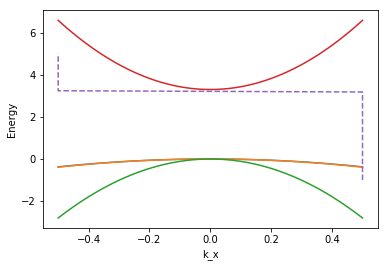

In [12]:
fermiEnergy = 3.2
k = np.linspace(-0.5,0.5,100)
k = np.stack([k,np.zeros(len(k)),np.zeros(len(k))],axis=1)
E = np.linspace(-1,5,100)
plt.xlabel('k_x')
plt.ylabel('Energy')
old_band = 0
test = []
for i, band_info in enumerate(bands):
    band_energies = band(k, band_info[2], band_info[1], band_info[0])
    plt.plot(k[:,0],band_energies)
    old_band = band_energies
#plt.plot([-0.5,0.5],[fermiEnergy,fermiEnergy],'--')
plt.plot(fermiDirac(E,fermiEnergy,10)-0.5,E,'--')
plt.show()

In [13]:
direct = []

for fermiEnergy in [3.6]:
    dEmin = 10
    for k in k_list:
        band_c = band(np.array([k[0]]), bands[-1][2], bands[-1][1], bands[-1][0])

        if band_c > fermiEnergy:
            for i, band_info in enumerate(bands[:-1]):
                band_v = band(np.array([k[0]]), band_info[2], band_info[1], band_info[0])
                dEmin = np.min([dEmin, band_c-band_v])

    direct.append(dEmin)
direct

[4.2142468102025887]

# Calculate histogram


In [14]:
eBin = np.linspace(3,7,80)

In [15]:
model = "Parabolic"
name = "Hexagonal projection {}"
title = name
notes = "Simple test of hexagonal projection "
meta = spectrum.createMeta(name=name, title=title, authors="Sindre R. Bilden", notes=notes, model=model, cell=lattice, fermi=fermiEnergy, coordinates=coordinates, effective_masses=eff_masses, energy_levels=energy_offset)

In [16]:
EELS = spectrum.calculate_spectrum((mesh,k_list,e_arr,w_arr),eBin,fermiEnergy, brillouinZone = BZ, temperature=0)

[[ 1.91142768  1.10356328 -0.        ]
 [ 0.          2.20712657  0.        ]
 [ 0.         -0.          1.18448374]]


TypeError: function takes exactly 9 arguments (5 given)

In [ ]:
signal = spectrum.createSignal(data=EELS,eBin=eBin,mesh=mesh,metadata=meta)

In [ ]:
signal.metadata

In [ ]:
spectrum.saveHyperspy(signal, filename='../Results/Schleife2009/five_bands/fermi_%.2f' %(fermiEnergy-band_gap))

In [ ]:
EELS_smooth = smooth(EELS, eBin, 0.02) #smoothing of data